In [10]:
from google.colab import files
files.upload()

Saving amazonfoodreviews100kcleansed.csv to amazonfoodreviews100kcleansed.csv


In [4]:
ls

amazonfoodreviews100kcleansed.csv  sample_data/


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

In [5]:
df = pd.read_csv("amazonfoodreviews100kcleansed.csv")
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleansed
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,negative,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,negative,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,negative,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...


In [6]:
data = pd.DataFrame({'review_text': df.cleansed ,'sentiment': df.Score})

In [7]:
data['sentiment'].value_counts()

negative    84670
positive    15330
Name: sentiment, dtype: int64


Dataset is heavily imbalanced

*   negative    84670
*   positive    15330


In [9]:

from sklearn.utils import resample

df_positive = data[data['sentiment'] == 'positive']
df_negative = data[data['sentiment'] == 'negative'].iloc[:3000] #Keeping only 3000 - low RAM

In [11]:
data_positive_upsampled = resample(df_positive,replace=True,n_samples=3000,random_state=99)

In [12]:
data = pd.concat([df_negative,data_positive_upsampled])

In [13]:
data.sentiment.value_counts()

positive    3000
negative    3000
Name: sentiment, dtype: int64

In [14]:
from sklearn.model_selection import train_test_split as tts
t_train, test = tts(data, test_size=0.3)
print(t_train.shape)
print(test.shape)

(4200, 2)
(1800, 2)


In [15]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer()
bow = bow.fit(t_train['review_text'])
bow_train = bow.transform(t_train['review_text'])
bow_test = bow.transform(test['review_text'])
print(bow_train.shape)
print(bow_test.shape)

(4200, 9607)
(1800, 9607)


In [16]:
t_train.sentiment.value_counts()

negative    2103
positive    2097
Name: sentiment, dtype: int64

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors = 2103, n_jobs = -1) #23168 is the majority
knn.fit(bow_train,t_train['sentiment'])
predict = knn.predict(bow_test)
accuracy = accuracy_score(test['sentiment'],predict)
print("Accuracy of Dumb (overfitted ) model is : ", accuracy*100)
dumb_probab = knn.predict_proba(bow_test)[:,1]
dumb_auc_test = roc_auc_score(test['sentiment'], dumb_probab)
print("AUC of dumb model :", dumb_auc_test*100)

Accuracy of Dumb (overfitted ) model is :  75.55555555555556
AUC of dumb model : 82.98956408157622


negative    84670
positive    80000
Name: sentiment, dtype: int64

In [24]:


from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from sklearn.preprocessing import MultiLabelBinarizer
binarizer = MultiLabelBinarizer() #binarize string labels



In [ ]:
train_label

In [33]:
def KNearestNeighbor(train_data, train_label, cv_data, cv_label, k_step = 2 ,algo="brute", n_jobs= -1 , metric= "cosine"):
  auc_cv=[]
  auc_train,f1=[],[]
  binarizer.fit(['positive','negative']) #f1-score
  k_range = range(1,60,k_step)
  i = 0
  for k in tqdm(k_range):
    knn = KNeighborsClassifier(n_neighbors=k,algorithm=algo,n_jobs=2,metric=metric)
    model = knn.fit(train_data, train_label)
    train_probability = model.predict_proba(train_data)[:,1]
    cv_probability = model.predict_proba(cv_data)[:,1]
    auc_train.append(roc_auc_score(train_label, train_probability))
    auc_cv.append(roc_auc_score(cv_label,cv_probability))
    f1.append(f1_score(binarizer.transform(cv_label), binarizer.transform(model.predict(cv_data)),average='macro'))
    print("Accuracy at k =",k,"=>",auc_cv[i])
    i+=1
  auc_train = np.array(auc_train)
  auc_cv = np.array(auc_cv)
  plt.scatter(k_range, auc_train)
  plt.plot(k_range, auc_train, label="Train")
  plt.scatter(k_range, auc_cv)
  plt.plot(k_range, auc_cv, label='Cv')
  plt.scatter(k_range, auc_train-auc_cv)
  plt.plot(k_range, auc_cv, label='AUC Diff')
  plt.grid()
  plt.xlabel('k')
  plt.ylabel('AUC')
  plt.legend()
  plt.title('AUC score V/S k')
  plt.show()
  plt.scatter(k_range, f1)
  plt.plot(k_range, f1)
  plt.title("k V/S F1 Scores")
  plt.xlabel('k-hyperparameter')
  plt.ylabel('F1-Scores')
  plt.show()
  index,= np.where(auc_cv==max(auc_cv))
  best_k = k_range[int(index)]
  print("Best k is: ", best_k)
  return best_k

In [26]:
sortbyTS = df.sort_values('Time', axis=0, ascending=True, kind = 'quicksort')
data = pd.DataFrame({'review_text': sortbyTS.cleansed ,'sentiment': sortbyTS.Score})
train_and_cv, test = tts(data, test_size=0.3, random_state=1)
train, cv = tts(train_and_cv, test_size=0.3, random_state=1)

In [27]:
from sklearn.preprocessing import Normalizer

bow = CountVectorizer()
bow = bow.fit(train['review_text'])


bow_train = bow.transform(train['review_text'])
bow_cv = bow.transform(cv['review_text'])
bow_test = bow.transform(test['review_text'])


bow_train = Normalizer().fit_transform(bow_train)
bow_cv = Normalizer().fit_transform(bow_cv)
bow_test = Normalizer().fit_transform(bow_test)

print("BOW Train : ", bow_train.shape, "BOW CV", bow_cv.shape, "BOW Test", bow_test.shape)

BOW Train :  (49000, 27245) BOW CV (21000, 27245) BOW Test (30000, 27245)






  0%|          | 0/30 [00:00<?, ?it/s]



  3%|▎         | 1/30 [03:17<1:35:40, 197.94s/it]

Accuracy at k = 1 => 0.6277214039663663






  7%|▋         | 2/30 [06:52<1:34:45, 203.05s/it]

Accuracy at k = 3 => 0.7194850146970502






 10%|█         | 3/30 [10:49<1:35:54, 213.12s/it]

Accuracy at k = 5 => 0.7554459132844629






 13%|█▎        | 4/30 [14:47<1:35:38, 220.71s/it]

Accuracy at k = 7 => 0.7745109304574905






 17%|█▋        | 5/30 [18:47<1:34:20, 226.44s/it]

Accuracy at k = 9 => 0.7887848829609369






 20%|██        | 6/30 [22:45<1:31:58, 229.92s/it]

Accuracy at k = 11 => 0.7958636490052253






 23%|██▎       | 7/30 [26:39<1:28:30, 230.91s/it]

Accuracy at k = 13 => 0.8078297456227342






 27%|██▋       | 8/30 [30:17<1:23:20, 227.31s/it]

Accuracy at k = 15 => 0.815917015728961






 30%|███       | 9/30 [34:00<1:19:03, 225.88s/it]

Accuracy at k = 17 => 0.819949405775809






 33%|███▎      | 10/30 [37:40<1:14:44, 224.21s/it]

Accuracy at k = 19 => 0.8217835614478004






 37%|███▋      | 11/30 [41:18<1:10:21, 222.20s/it]

Accuracy at k = 21 => 0.825132428113789






 40%|████      | 12/30 [44:50<1:05:44, 219.13s/it]

Accuracy at k = 23 => 0.8281351734869187






 43%|████▎     | 13/30 [48:19<1:01:14, 216.16s/it]

Accuracy at k = 25 => 0.8308939108740871






 47%|████▋     | 14/30 [51:46<56:52, 213.29s/it]  

Accuracy at k = 27 => 0.8328740267274077






 50%|█████     | 15/30 [55:11<52:42, 210.85s/it]

Accuracy at k = 29 => 0.83429488516911






 53%|█████▎    | 16/30 [58:35<48:44, 208.88s/it]

Accuracy at k = 31 => 0.8367409075820337






 57%|█████▋    | 17/30 [1:01:55<44:40, 206.21s/it]

Accuracy at k = 33 => 0.8381771111322863






 60%|██████    | 18/30 [1:05:10<40:35, 202.98s/it]

Accuracy at k = 35 => 0.8387383926450324






 63%|██████▎   | 19/30 [1:08:24<36:40, 200.02s/it]

Accuracy at k = 37 => 0.8396935953772713






 67%|██████▋   | 20/30 [1:11:37<32:59, 197.99s/it]

Accuracy at k = 39 => 0.8411694332496082






 70%|███████   | 21/30 [1:14:51<29:32, 196.90s/it]

Accuracy at k = 41 => 0.8415086691386305






 73%|███████▎  | 22/30 [1:18:06<26:11, 196.40s/it]

Accuracy at k = 43 => 0.8427079490568694






 77%|███████▋  | 23/30 [1:21:17<22:43, 194.74s/it]

Accuracy at k = 45 => 0.8427115042088503






 80%|████████  | 24/30 [1:24:26<19:17, 192.87s/it]

Accuracy at k = 47 => 0.8429039322160711






 83%|████████▎ | 25/30 [1:27:33<15:56, 191.31s/it]

Accuracy at k = 49 => 0.8437499113374506






 87%|████████▋ | 26/30 [1:30:41<12:40, 190.20s/it]

Accuracy at k = 51 => 0.8447819780125182






 90%|█████████ | 27/30 [1:33:49<09:28, 189.59s/it]

Accuracy at k = 53 => 0.845640750491026






 93%|█████████▎| 28/30 [1:36:57<06:18, 189.17s/it]

Accuracy at k = 55 => 0.8454891678065644






 97%|█████████▋| 29/30 [1:40:04<03:08, 188.28s/it]

Accuracy at k = 57 => 0.8454755699989877






100%|██████████| 30/30 [1:43:05<00:00, 206.20s/it]

Accuracy at k = 59 => 0.8460328465595022


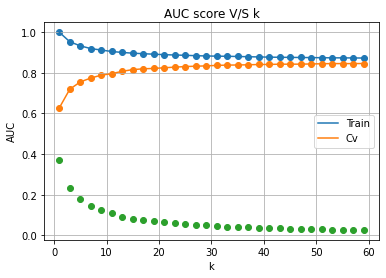

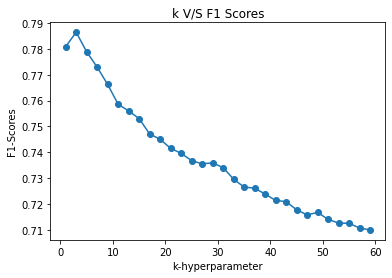

Best k is:  59


In [34]:
best_K_bow = KNearestNeighbor(bow_train, train['sentiment'], bow_cv, cv['sentiment'])

In [36]:
best_k = 59

In [39]:
knn = KNeighborsClassifier(n_neighbors=best_k,algorithm='brute',n_jobs=2,metric='cosine')
model = knn.fit(bow_train, train['sentiment'],)


In [71]:
 querybow = bow.transform(["product advertis packet receiv box packet "])
 querybow = Normalizer().fit_transform(querybow)

In [72]:
knn.predict(querybow.todense())

array(['positive'], dtype=object)